In [1]:
# jack's car rental
import numpy as np
import sys
sys.path.append('C:\Program Files\python36\Lib\site-packages')
import gym
from gym.utils import seeding
from gym import Env, spaces
from gym.envs.toy_text import discrete
from scipy.stats import poisson

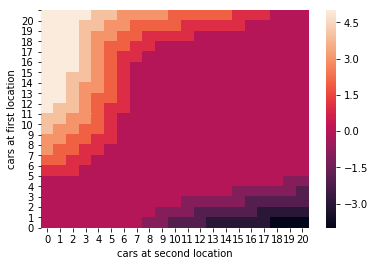

In [11]:
import seaborn
policy = np.load('policy.npy')
sbn_fig = seaborn.heatmap(np.flipud(policy))
sbn_fig.set_ylabel("cars at first location")
sbn_fig.set_xlabel("cars at second location")
sbn_fig.set_yticks(list(reversed(range(0, policy.shape[1] + 1))))
sbn_fig

In [39]:
# car rental enviroment
# distribution model is difficult, try to establish a sample model

def categorical_sample(prob_n, np_random):
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np_random.rand()).argmax()

class CarRentalEnv(Env):
    # action means take how many cars from place one to place two, -5 means take 5 cars from place two to place one
    def __init__(self, max_cars, max_removeable_cars, isd=None):
        self.max_cars = max_cars
        self.nS = max_cars ** 2
        self.nA = 2 * max_removeable_cars + 1
        if isd == None:
            self.isd = np.ones(self.nS) / self.nS
        self.max_removeable_cars = max_removeable_cars
        self.shape = (max_cars, max_cars)
        self.observation_space = spaces.Discrete(self.nS)
        self.action_space = spaces.Discrete(self.nA)

        self.seed()
        self.s = categorical_sample(self.isd, self.np_random)
        self.lastaction = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _render(self):
        pass
    
    def reset(self):
        self.s = categorical_sample(self.isd, self.np_random)
        self.lastaction = None
        return self.s
    
    def step(self,a):
        x, y = np.unravel_index(self.s, self.shape)
        # resize action
        if a - self.max_removeable_cars > x:
            a = self.max_removeable_cars + x
        if self.max_removeable_cars - a > y:
            a = self.max_removeable_cars - y
        available_x = x - (a - self.max_removeable_cars)
        available_y = y + (a - self.max_removeable_cars)
        # sample rent cars and return cars
        rent_cars_in_x = np.random.poisson(3)
        print(f"{rent_cars_in_x} cars wanted in place one")
        return_cars_in_x = np.random.poisson(3)
        print(f"{return_cars_in_x} cars returned in place one")
        actual_rent_cars_in_x = min(rent_cars_in_x, available_x)
        print(f"{actual_rent_cars_in_x} cars rented actually")
        newx = min(available_x - actual_rent_cars_in_x + return_cars_in_x, self.max_cars)
        print(f"newx is {newx}")
              
        rent_cars_in_y = np.random.poisson(4)
        print(f"{rent_cars_in_y} cars wanted in place two")
        return_cars_in_y = np.random.poisson(2)
        print(f"{return_cars_in_y} cars returned in place two")
        actual_rent_cars_in_y = min(rent_cars_in_y, available_y)
        print(f"{actual_rent_cars_in_y} cars rented actually")
        newy = min(available_y - actual_rent_cars_in_y + return_cars_in_y, self.max_cars)
        print(f"newy is {newy}")
              
        s = np.ravel_multi_index((newx, newy), self.shape)
        self.s = s
        self.lastaction = a
        rewards = 10 * (actual_rent_cars_in_x + actual_rent_cars_in_y) - 2 * abs(a - self.max_removeable_cars)
        # output infomation
        if a < self.max_removeable_cars:
            print(f"Action: Take {self.max_removeable_cars - a} cars  from place two to place one")
        elif a == self.max_removeable_cars:
            print(f"Action: No cars are moved")
        else:
            print(f"Action: Take {a - self.max_removeable_cars} cars from place two to place one")
        print(f"Next State is ({newx},{newy})")
        return (s, rewards, False, '')

In [254]:
# dynamic env
class CarRentEnvV2(discrete.DiscreteEnv):
    
    def __init__(self, max_cars=20, max_moveable_cars=5):
        self.shape = (max_cars + 1, max_cars + 1)
        self.max_cars = max_cars
        self.moveable_cars = max_moveable_cars
        self.rent_prob_at_1 = self._init_prob(3)
        self.rent_prob_at_2 = self._init_prob(4)
        self.rent_prob_at_1_bound = self._init_prob_bound(3)
        self.rent_prob_at_2_bound = self._init_prob_bound(4)
        self.return_prob_at_1 = self._init_prob(3)
        self.return_prob_at_2 = self._init_prob(2)
        self.return_prob_at_1_bound = self._init_prob_bound(3)
        self.return_prob_at_2_bound = self._init_prob_bound(2)
        nS = np.prod(self.shape)
        nA = 2 * max_moveable_cars + 1
        
        P = {}
        # calculate the prob for each s,a :(pb, next_state, reward, done)
        for state in range(nS):
            P[state] = {a:[] for a in range(nA)}
            x, y = np.unravel_index(state, self.shape)
            # calculate the range of actions
            max_action = self.moveable_cars + min(self.moveable_cars, x)
            min_action = self.moveable_cars - min(self.moveable_cars, y)
            for action in range(min_action, max_action + 1):
                a = action - self.moveable_cars
                available_x = x - a
                available_y = y + a
                for rent_1 in range(available_x + 1):
                    max_return_at_1 = self.max_cars - (available_x - rent_1)
                    prob_rent_1 = self.rent_prob_at_1[rent_1] if rent_1 != available_x else self.rent_prob_at_1_bound[available_x]
                    for rent_2 in range(available_y + 1):
                        max_return_at_2 = self.max_cars - (available_y - rent_2)
                        prob_rent_2 = self.rent_prob_at_2[rent_2] if rent_2 != available_y else self.rent_prob_at_2_bound[available_y]
                        for return_1 in range(max_return_at_1 + 1):
                            prob_return_1 = self.return_prob_at_1[return_1] if return_1 != max_return_at_1 else self.return_prob_at_1_bound[max_return_at_1]
                            for return_2 in range(max_return_at_2 + 1):
                                prob_return_2 = self.return_prob_at_2[return_2] if return_2 != max_return_at_2 else self.return_prob_at_2_bound[max_return_at_2]
                                # cal next state
                                newx = available_x - rent_1 + return_1
                                newy = available_y - rent_2 + return_2
                                assert newx <= self.max_cars, f"error: newx:{newx}"
                                assert newy <= self.max_cars, f"error: newy:{newy}"
                                next_state = np.ravel_multi_index((newx, newy), self.shape)
                                # cal prob
                                prob = prob_rent_1 * prob_rent_2 * prob_return_1 * prob_return_2
                                # cal reward
                                reward = 10 * rent_1 + 10 * rent_2 - 2 * abs(a)
                                P[state][action].append((prob, next_state, reward, False))
        isd = np.ones(nS)/ nS
        super().__init__(nS, nA, P, isd)
    
    def _render(self):
        pass
    
    # these array speed up the calculation
    def _init_prob(self, lam):
        prob_array = np.zeros(self.max_cars * 2 + 1)
        for i in range(self.max_cars * 2 + 1):
            prob_array[i] = poisson.pmf(i, lam)
        return prob_array
    
    # arr[i] means the probality that greater than or equal 
    def _init_prob_bound(self, lam):
        # prob_bound_array[0] must be 1
        prob_bound_array = np.ones(self.max_cars * 2 + 1)
        for i in range(1, self.max_cars * 2 + 1):
            prob_bound_array[i] = 1 - poisson.cdf(i - 1, lam)
        return prob_bound_array
    

In [149]:
def random_init_policy(env):
    moveable_cars = env.moveable_cars
    policy = np.random.randint(env.nA, size=env.shape)
    for i in range(env.shape[0]):
        for j in range(env.shape[1]):
            if policy[i][j] - moveable_cars > i:
                policy[i][j] = moveable_cars + i
            if moveable_cars - policy[i][j] > j:
                policy[i][j] = moveable_cars -j
                
    return policy - moveable_cars
    
def policy_eval(env, policy, theta=0.01, gamma = 0.9):
    V = np.zeros(env.shape)
    while True:
        delta = 0
        for state in range(env.nS):
            x, y = np.unravel_index(state, env.shape)
            v = 0
            a = policy[x][y] + env.moveable_cars
            for re_iter in env.P[state][a]:
                prob, next_state, reward, _ = re_iter
                next_x, next_y = np.unravel_index(next_state, env.shape)
                v += prob * (reward  + gamma * V[next_x][next_y])
            delta = max(delta, abs(v - V[x][y]))
            V[x][y] = v
        if delta < theta:
            break
    return V


def policy_improve(env, V, gamma=0.9):
    policy = np.zeros(env.shape)
    def look_onestep_ahead(state, V):
        A = np.zeros(env.nA)
        for action in range(env.nA):
            for re_iter in env.P[state][action]:
                prob, next_state, reward, _ = re_iter
                next_x, next_y = np.unravel_index(next_state, env.shape)
                A[action] += prob * (reward  + gamma * V[next_x][next_y])
            
        return A
    for i in range(env.max_cars + 1):
        for j in range(env.max_cars + 1):
            state = np.ravel_multi_index((i, j), env.shape)
            A = look_onestep_ahead(state, V)
            best_a = np.argmax(A) - env.moveable_cars
            policy[i][j] = best_a
        
    return policy

def policy_iteration(env):
    my_policy = random_init_policy(env)
    while True:
        policy_stable = True
        V = policy_eval(env, my_policy)
        policy = policy_improve(env, V)
        for i in range(policy.shape[0]):
            for j in range(policy.shape[1]):
                if policy[i][j] != my_policy[i][j]:
                    policy_stable = False
                    break
        if policy_stable:
            break
        my_policy = policy
    return policy, V

In [255]:
# policy iteration to solve the car rental problem
env = CarRentEnvV2(20, 5)
print("env done!")
policy, V = policy_iteration(env)

np.save('policy', policy)
np.save('V', V)

env done!
